In [9]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [10]:
!cp /content/drive/MyDrive/ВКР/WESAD.zip /content/WESAD.zip

In [11]:
!pip install neurokit2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.3 MB/s eta 0:00:00


In [12]:
import neurokit2 as nk

In [13]:
import numpy as np
import pandas as pd
import zipfile
import pickle
import matplotlib.pyplot as plt
import time
import joblib

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import GradientBoostingClassifier

In [24]:
import warnings

warnings.filterwarnings("ignore")

In [15]:
zip_file_path = 'WESAD.zip'
extracted_path = 'WESAD'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

In [16]:
def print_dataset_from(name):
  print()
  print('-'*20)
  print()
  print(f"DATASET FROM {name}")
  print()
  print('-'*20)
  print()

In [17]:
def make_df(name):
  path = f'WESAD/WESAD/{name}/{name}.pkl'
  with open(path, 'rb') as f:
      dataset = pickle.load(f, encoding='latin1')

  print_dataset_from(name)
  chest = dataset['signal']['chest']
  wrist = dataset['signal']['wrist']
  label = dataset['label']

  df_chest = pd.DataFrame({key: [x[0] for x in value] for key, value in chest.items()})
  df_chest[['ACC_x', 'ACC_y', 'ACC_z']] = pd.DataFrame(chest['ACC'])
  df_chest = df_chest.drop(columns=['ACC'])
  df_chest['label'] = label

  return df_chest

0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement,
4 = meditation, 5/6/7 = should be ignored in this dataset

In [18]:
def get_metrics_ECG(peaks, data_length, sampling_rate, window_size, delta):
    window_length = window_size * sampling_rate  # Длина окна в отсчетах
    window_delta = delta * sampling_rate

    def hrv_indices_for_window(peaks):
        '''
        MeanNN: среднее значение интервалов RR.
        SDNN: стандартное отклонение интервалов RR.
        SDSD: Стандартное отклонение последовательных различий между интервалами RR.
        CVSD: Среднеквадратичный результат последовательных различий (RMSSD), деленный на среднее значение интервалов RR (MeanNN).
        Prc20NN: 20-я процентиль интервалов RR (Хан, 2017; Овсепян, 2015).
        Prc80NN: 80-я процентиль интервалов RR (Хан, 2017; Овсепян, 2015).
        pNN20: доля интервалов RR, превышающих 20 мс, от общего числа интервалов RR.
        '''
        hrv_indices = nk.hrv(peaks, sampling_rate=sampling_rate, show=False)
        return hrv_indices[['HRV_MeanNN', 'HRV_SDNN', 'HRV_SDSD', 'HRV_CVSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN20']]

    df_hrv_indices = pd.DataFrame(columns=['HRV_MeanNN', 'HRV_SDNN', 'HRV_SDSD', 'HRV_CVSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN20'])

    # Применение скользящего окна
    for i in range(0, data_length - window_length + 1, window_delta):
        hrv_indices = hrv_indices_for_window(peaks[i:i + window_length])
        df_hrv_indices = pd.concat([df_hrv_indices, hrv_indices], ignore_index=True)

    return df_hrv_indices

In [19]:
def get_EDA_info(df_EDA, sampling_rate, window_size, delta):
    window_length = window_size * sampling_rate  # Длина окна в отсчетах
    window_delta = delta * sampling_rate

    def calculate_metrics_for_window_eda(eda_window):
        eda_level = np.mean(eda_window)
        cv_eda = np.std(eda_window) / eda_level
        return eda_level, cv_eda

    eda_level_values = np.array([])
    eda_cv_values = np.array([])

    for i in range(0, len(df_EDA) - window_length + 1, window_delta):
        window_eda = df_EDA[i:i+window_length]
        eda_level, eda_cv = calculate_metrics_for_window_eda(window_eda)
        eda_level_values = np.append(eda_level_values, np.array([eda_level]))
        eda_cv_values = np.append(eda_cv_values, np.array([eda_cv]))

    return eda_level_values, eda_cv_values

In [20]:
def get_full_data(df, sampling_rate, window_size, delta):
    # ECG
    ecg_cleaned = nk.ecg_clean(df["ECG"], sampling_rate=sampling_rate)
    rpeaks, info = nk.ecg_peaks(ecg_cleaned, sampling_rate=sampling_rate)
    df_hrv_indices = get_metrics_ECG(rpeaks, len(df["ECG"]), sampling_rate, window_size, delta)
    # EDA
    eda_level_values, eda_cv_values = get_EDA_info(df['EDA'], sampling_rate, window_size, delta)
    df_hrv_indices.loc[:, 'EDA_Level'] = eda_level_values
    df_hrv_indices.loc[:, 'EDA_CV'] = eda_cv_values
    return df_hrv_indices

In [21]:
def create_data_for_one_person(df_chest, sampling_rate, window_size, delta):
    df_baseline = df_chest[df_chest.label == 1]
    df_stress = df_chest[df_chest.label == 2]

    df_baseline = df_baseline.reset_index(drop=True)
    df_stress = df_stress.reset_index(drop=True)

    df_baseline_indices = get_full_data(df_baseline, sampling_rate, window_size, delta)
    df_stress_indices = get_full_data(df_stress, sampling_rate, window_size, delta)

    df_concat = pd.concat([df_stress_indices, df_baseline_indices], ignore_index=True)
    df_concat = df_concat.reset_index()
    df_concat = df_concat.drop(columns=['index'])

    df_stress_label = pd.DataFrame([1] * len(df_stress_indices))
    df_baseline_label = pd.DataFrame([0] * len(df_baseline_indices))
    label = pd.concat([df_stress_label, df_baseline_label], ignore_index=True)

    return df_concat, label

In [22]:
dict_fi = {}

In [25]:
X_train_all = pd.DataFrame()
y_train_all = pd.DataFrame()
X_test_all = pd.DataFrame()
y_test_all = pd.DataFrame()

sampling_rate = 700
window_size = 30 # 60 30
delta = 7 # для 60: 20 и 15; для 30: 10 и 7

time_list = []
start_time = time.time()
for i in range(2, 18):
    if i == 12:
        continue
    df_chest = make_df(f'S{i}')
    df_one_person, y = create_data_for_one_person(df_chest, sampling_rate, window_size=window_size, delta=delta)
    X = df_one_person[['HRV_MeanNN', 'HRV_SDNN', 'HRV_SDSD', 'HRV_CVSD', 'HRV_Prc20NN', 'HRV_Prc80NN',
                        'HRV_pNN20', 'EDA_Level', 'EDA_CV']]

    # Находим строки, где есть NaN
    rows_with_nan = np.isnan(X).any(axis=1)

    # Удаляем строки
    X = X[~rows_with_nan]
    y = y[~rows_with_nan]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_all = pd.concat([X_train_all, X_train], ignore_index=True)
    X_test_all = pd.concat([X_test_all, X_test], ignore_index=True)
    y_train_all = pd.concat([y_train_all, y_train], ignore_index=True)
    y_test_all = pd.concat([y_test_all, y_test], ignore_index=True)


end_time = time.time()

# Вычисляем время выполнения
execution_time = end_time - start_time


--------------------

DATASET FROM S2

--------------------


--------------------

DATASET FROM S3

--------------------


--------------------

DATASET FROM S4

--------------------


--------------------

DATASET FROM S5

--------------------


--------------------

DATASET FROM S6

--------------------


--------------------

DATASET FROM S7

--------------------


--------------------

DATASET FROM S8

--------------------


--------------------

DATASET FROM S9

--------------------


--------------------

DATASET FROM S10

--------------------


--------------------

DATASET FROM S11

--------------------


--------------------

DATASET FROM S13

--------------------


--------------------

DATASET FROM S14

--------------------


--------------------

DATASET FROM S15

--------------------


--------------------

DATASET FROM S16

--------------------


--------------------

DATASET FROM S17

--------------------



In [26]:
time_list.append([execution_time, window_size, delta])
time_list

[[534.9779069423676, 30, 7]]

In [27]:
print('len(X_train_all)', len(X_train_all))
print('len(X_test_all)', len(X_test_all))
print('len(all)', len(X_test_all) + len(X_train_all))

len(X_train_all) 3058
len(X_test_all) 770
len(all) 3828


In [28]:
X_train_all.head(5)

,HRV_MeanNN,HRV_SDNN,HRV_SDSD,HRV_CVSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN20,EDA_Level,EDA_CV
0,811.666667,56.760455,47.671812,0.057909,762.857143,860.000000,63.888889,1.150516,0.015379
1,854.117647,69.995816,83.189618,0.095917,797.428571,906.000000,82.352941,1.220644,0.014760
2,865.210084,85.164821,56.415042,0.064241,818.000000,929.428571,55.882353,3.978831,0.025364
3,805.173745,51.550067,49.424072,0.060532,762.000000,844.285714,78.378378,1.564569,0.013886
4,704.390244,72.384595,52.337861,0.073371,651.428571,738.571429,56.097561,5.160336,0.034991


КРОСС-ВАЛИДАЦИЯ МЕТОДА RF

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier


rf_model = RandomForestClassifier()


X_all = pd.concat([X_train_all, X_test_all])
y_all = pd.concat([y_train_all, y_test_all])

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1_score': make_scorer(f1_score, average='macro')
}


cv_results = cross_validate(rf_model, X_all, y_all[0], cv=15, scoring=scoring, return_estimator=True)


print("Accuracy: ", np.mean(cv_results['test_accuracy']))
print("Precision: ", np.mean(cv_results['test_precision']))
print("Recall: ", np.mean(cv_results['test_recall']))
print("F1-score: ", np.mean(cv_results['test_f1_score']))

Accuracy:  0.971546160130719
Precision:  0.9720065718129484
Recall:  0.9664782071940077
F1-score:  0.9686228122646852


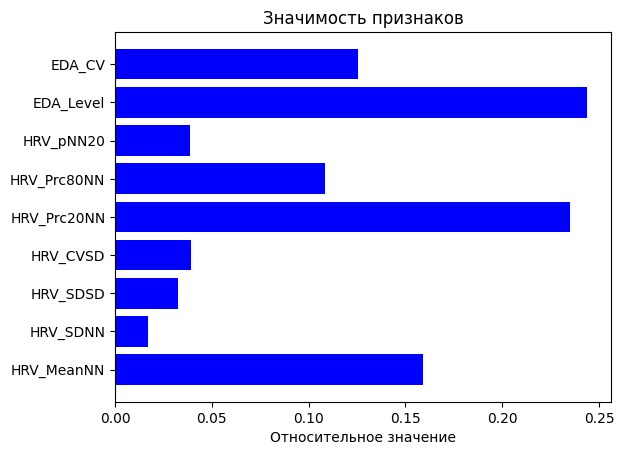

In [ ]:
feature_importances = []
for estimator in cv_results['estimator']:
    feature_importances.append(estimator.feature_importances_)

# Среднее значение значимости признаков
mean_importance = np.mean(feature_importances, axis=0)
dict_fi[f'RF_{window_size}_{delta}'] = mean_importance


features = X_train_all.columns

plt.title('Значимость признаков')
plt.xlabel('Относительное значение')
plt.barh(range(len(features)), mean_importance, color='b', align='center')
plt.yticks(range(len(features)), features)
plt.show()

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, min_samples_split=2)


start_time = time.time()
rf_model.fit(X_train_all, y_train_all[0])
end_time = time.time()

# Вычисляем время выполнения
end_time - start_time

1.6418042182922363

In [ ]:
start_time = time.time()
y_pred_RF = rf_model.predict(X_test_all)
end_time = time.time()
end_time - start_time

0.07826876640319824

In [ ]:
accuracy_RF = accuracy_score(y_test_all, y_pred_RF)
conf_matrix_RF = confusion_matrix(y_test_all, y_pred_RF)
classification_rep_RF = classification_report(y_test_all, y_pred_RF)

print(f'Accuracy: {accuracy_RF}')
print(f'Confusion Matrix:\n{conf_matrix_RF}')
print(f'Classification Report:\n{classification_rep_RF}')

Accuracy: 0.990909090909091
Confusion Matrix:
[[469   1]
 [  6 294]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       470
           1       1.00      0.98      0.99       300

    accuracy                           0.99       770
   macro avg       0.99      0.99      0.99       770
weighted avg       0.99      0.99      0.99       770



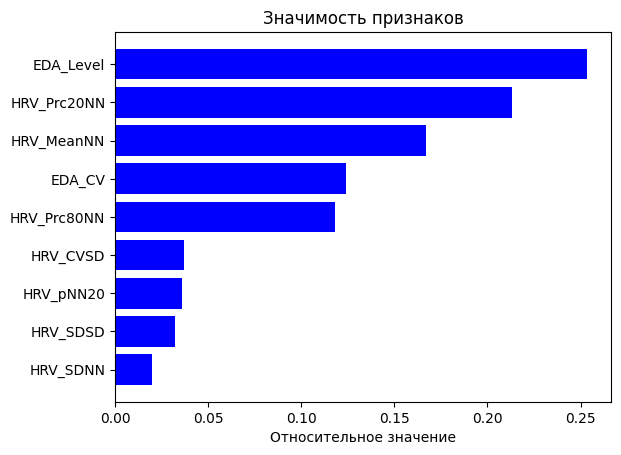

{'RF_30_7': array([0.16673167, 0.01956203, 0.0323584 , 0.03680575, 0.21331022,
       0.11807548, 0.03570049, 0.25370513, 0.12375083])}


In [ ]:
features = X_train_all.columns
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.title('Значимость признаков')
plt.xlabel('Относительное значение')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.show()

dict_fi[f'RF_{window_size}_{delta}'] = importances
print(dict_fi)

In [ ]:
# Получение параметров модели
params = rf_model.get_params()

print("Параметры модели Random Forest:")
for param, value in params.items():
    print(f"{param}: {value}")

Параметры модели Random Forest:
bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False


In [ ]:
date = '15_04'
# # save
joblib.dump(rf_model, f"/content/drive/MyDrive/ВКР/модель-дата-точность/random_forest_{window_size}-{delta}-{int(accuracy_RF * 100000)}.joblib")

# # load
# loaded_rf = joblib.load("random_forest_14_04-09572.joblib")


['/content/drive/MyDrive/ВКР/модель-дата-точность/random_forest_30-7-99090.joblib']

In [ ]:
svm_model2 = SVC(kernel='linear', gamma='scale', degree=3, C=1.0)

start_time = time.time()
svm_model2.fit(X_train_all, y_train_all[0])
end_time = time.time()

# Вычисляем время выполнения
end_time - start_time

12.448431015014648

In [ ]:
start_time = time.time()
y_pred_svm2 = svm_model2.predict(X_test_all)
end_time = time.time()

# Вычисляем время выполнения
end_time - start_time

0.018779277801513672

Accuracy: 0.8788990825688073
Confusion Matrix:
[[324  15]
 [ 51 155]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       339
           1       0.91      0.75      0.82       206

    accuracy                           0.88       545
   macro avg       0.89      0.85      0.87       545
weighted avg       0.88      0.88      0.88       545



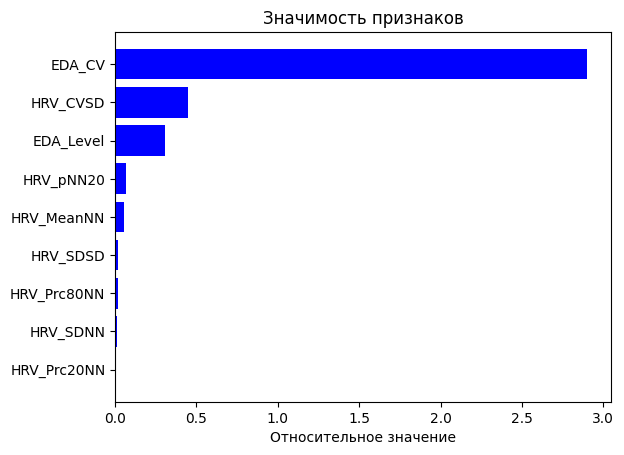

{'RF_60_20': array([0.18331943, 0.01571029, 0.03427661, 0.04699491, 0.24555442,
       0.09415695, 0.04034187, 0.23327112, 0.10637441]), 'SVM_60_20': array([5.47104452e-02, 1.78918376e-02, 2.36399687e-02, 2.15209871e-01,
       8.67183132e-06, 2.40412174e-02, 6.01732837e-02, 2.68229773e-01,
       1.75690605e+00]), 'KNN_60_20': array([0.25110471, 0.07569645, 0.09462056, 0.        , 0.30768492,
       0.17550432, 0.13823247, 0.01277618, 0.        ]), 'k-mean_60_20': array([2.58610203e+07, 2.42228192e+05, 2.93485663e+05, 7.53272410e-02,
       2.26817450e+07, 2.83376678e+07, 7.20221361e+05, 1.27215238e+02,
       6.81060739e-03]), 'gbn_60_20': array([0.07050913, 0.        , 0.0142171 , 0.00192123, 0.22103746,
       0.08107589, 0.01440922, 0.15888569, 0.09433237]), 'RF_60_15': array([0.21492988, 0.02135033, 0.03113035, 0.04822107, 0.2315745 ,
       0.09908345, 0.03753751, 0.20938722, 0.10678569]), 'SVM_60_15': array([0.06195866, 0.01094581, 0.0116518 , 0.32087265, 0.01655006,
       0.0

In [ ]:
accuracy_svm = accuracy_score(y_test_all, y_pred_svm2)
conf_matrix_svm = confusion_matrix(y_test_all, y_pred_svm2)
classification_rep_svm = classification_report(y_test_all, y_pred_svm2)

print(f'Accuracy: {accuracy_svm}')
print(f'Confusion Matrix:\n{conf_matrix_svm}')
print(f'Classification Report:\n{classification_rep_svm}')

features = X_train_all.columns
importances = np.abs(svm_model2.coef_[0])
indices = np.argsort(importances)

plt.title('Значимость признаков')
plt.xlabel('Относительное значение')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])

plt.show()

dict_fi[f'SVM_{window_size}_{delta}'] = importances
print(dict_fi)

In [ ]:
model = KNeighborsClassifier(n_neighbors=6, p=2, weights='distance')
start_time = time.time()
model.fit(X_train_all, y_train_all)
end_time = time.time()
end_time - start_time

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.010527372360229492

In [ ]:
# Прогнозирование на тестовых данных
start_time = time.time()
y_pred = model.predict(X_test_all)
end_time = time.time()
end_time - start_time

0.015248775482177734
Accuracy: 0.8899082568807339


In [ ]:
accuracy_knn = accuracy_score(y_test_all, y_pred)
conf_matrix_knn = confusion_matrix(y_test_all, y_pred)
classification_rep_knn = classification_report(y_test_all, y_pred)

print(f'Accuracy: {accuracy_knn}')
print(f'Confusion Matrix:\n{conf_matrix_knn}')
print(f'Classification Report:\n{classification_rep_knn}')

Accuracy: 0.8899082568807339
Confusion Matrix:
[[323  16]
 [ 44 162]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.92       339
           1       0.91      0.79      0.84       206

    accuracy                           0.89       545
   macro avg       0.90      0.87      0.88       545
weighted avg       0.89      0.89      0.89       545



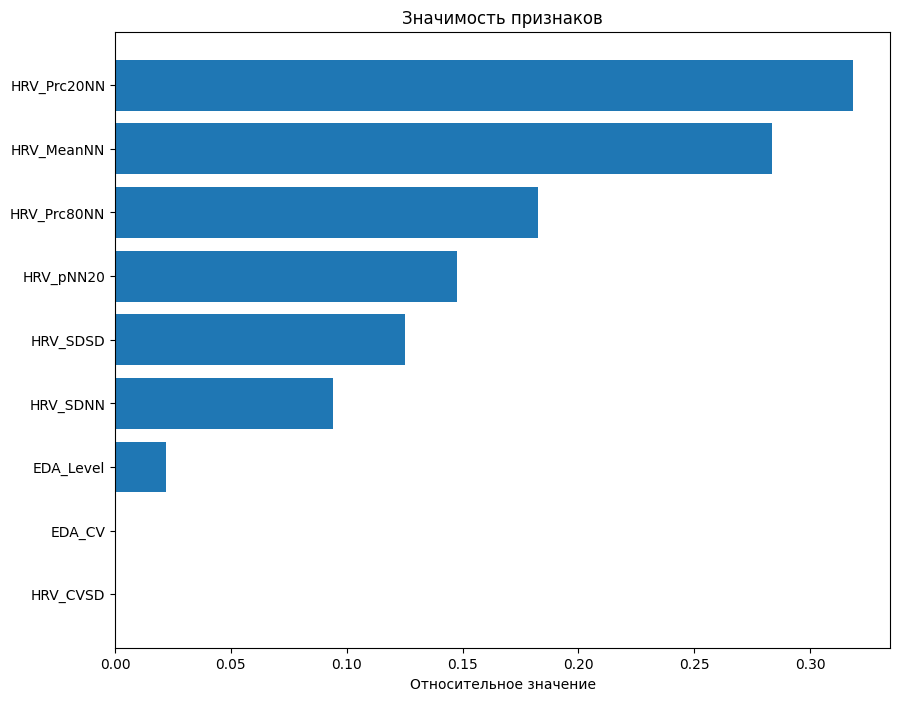

{'RF_60_20': array([0.18331943, 0.01571029, 0.03427661, 0.04699491, 0.24555442,
       0.09415695, 0.04034187, 0.23327112, 0.10637441]), 'SVM_60_20': array([5.47104452e-02, 1.78918376e-02, 2.36399687e-02, 2.15209871e-01,
       8.67183132e-06, 2.40412174e-02, 6.01732837e-02, 2.68229773e-01,
       1.75690605e+00]), 'KNN_60_20': array([0.25110471, 0.07569645, 0.09462056, 0.        , 0.30768492,
       0.17550432, 0.13823247, 0.01277618, 0.        ]), 'k-mean_60_20': array([2.58610203e+07, 2.42228192e+05, 2.93485663e+05, 7.53272410e-02,
       2.26817450e+07, 2.83376678e+07, 7.20221361e+05, 1.27215238e+02,
       6.81060739e-03]), 'gbn_60_20': array([0.07050913, 0.        , 0.0142171 , 0.00192123, 0.22103746,
       0.08107589, 0.01440922, 0.15888569, 0.09433237]), 'RF_60_15': array([0.21492988, 0.02135033, 0.03113035, 0.04822107, 0.2315745 ,
       0.09908345, 0.03753751, 0.20938722, 0.10678569]), 'SVM_60_15': array([0.06195866, 0.01094581, 0.0116518 , 0.32087265, 0.01655006,
       0.0

In [ ]:

result = permutation_importance(model, X_train_all, y_train_all, n_repeats=10, random_state=42)

sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 8))
plt.barh(X_train_all.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.title('Значимость признаков')
plt.xlabel('Относительное значение')
plt.show()

dict_fi[f'KNN_{window_size}_{delta}'] = result.importances_mean
print(dict_fi)

In [ ]:
# Получение параметров модели
params = model.get_params()

print("Параметры модели KNN:")
for param, value in params.items():
    print(f"{param}: {value}")

Параметры модели KNN:
algorithm: auto
leaf_size: 30
metric: minkowski
metric_params: None
n_jobs: None
n_neighbors: 5
p: 2
weights: uniform


In [ ]:
#joblib.dump(model, "knn_14_04-09090.joblib")
joblib.dump(model, f"/content/drive/MyDrive/ВКР/модель-дата-точность/knn_{window_size}-{delta}-{int(accuracy_knn * 100000)}.joblib")


['/content/drive/MyDrive/ВКР/модель-дата-точность/knn_30-7-90389.joblib']

In [ ]:
kmeans = KMeans(n_clusters=2, max_iter=300, algorithm='lloyd')
start_time = time.time()
kmeans.fit(X_train_all)
end_time = time.time()
end_time - start_time

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.5614750385284424

In [ ]:
start_time = time.time()
y_pred_kmean = kmeans.predict(X_test_all)

end_time = time.time()
end_time - start_time

0.0036776065826416016

In [ ]:
accuracy_kmean = accuracy_score(y_test_all, y_pred_kmean)
conf_matrix_kmean = confusion_matrix(y_test_all, y_pred_kmean)
classification_rep_kmean = classification_report(y_test_all, y_pred_kmean)

print(f'Accuracy: {accuracy_kmean}')
print(f'Confusion Matrix:\n{conf_matrix_kmean}')
print(f'Classification Report:\n{classification_rep_kmean}')

Accuracy: 0.7522935779816514
Confusion Matrix:
[[268  71]
 [ 64 142]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       339
           1       0.67      0.69      0.68       206

    accuracy                           0.75       545
   macro avg       0.74      0.74      0.74       545
weighted avg       0.75      0.75      0.75       545



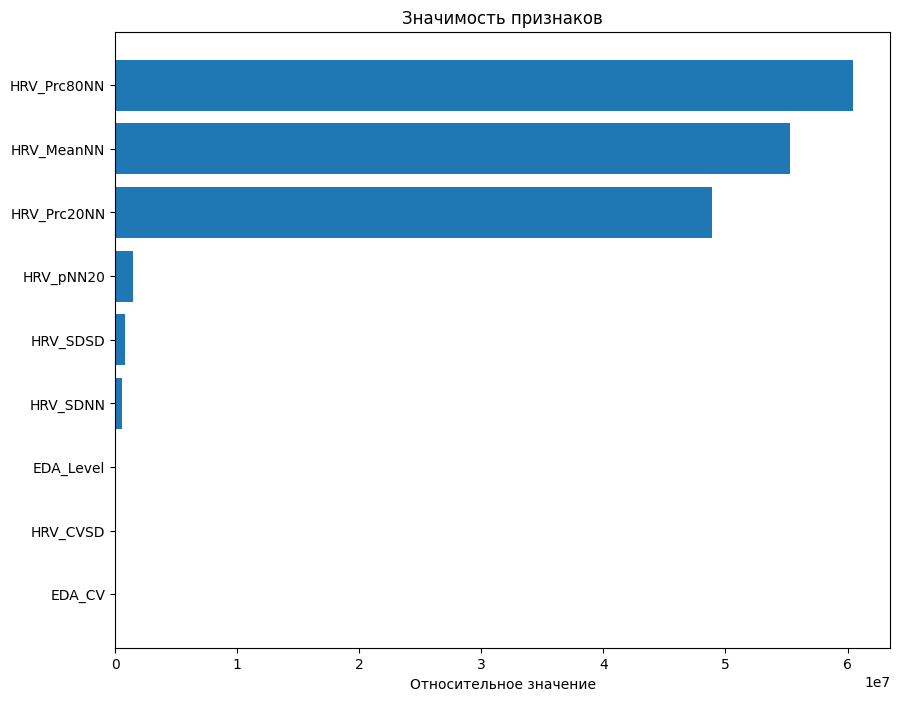

{'RF_60_20': array([0.18331943, 0.01571029, 0.03427661, 0.04699491, 0.24555442,
       0.09415695, 0.04034187, 0.23327112, 0.10637441]), 'SVM_60_20': array([5.47104452e-02, 1.78918376e-02, 2.36399687e-02, 2.15209871e-01,
       8.67183132e-06, 2.40412174e-02, 6.01732837e-02, 2.68229773e-01,
       1.75690605e+00]), 'KNN_60_20': array([0.25110471, 0.07569645, 0.09462056, 0.        , 0.30768492,
       0.17550432, 0.13823247, 0.01277618, 0.        ]), 'k-mean_60_20': array([2.58610203e+07, 2.42228192e+05, 2.93485663e+05, 7.53272410e-02,
       2.26817450e+07, 2.83376678e+07, 7.20221361e+05, 1.27215238e+02,
       6.81060739e-03]), 'gbn_60_20': array([0.07050913, 0.        , 0.0142171 , 0.00192123, 0.22103746,
       0.08107589, 0.01440922, 0.15888569, 0.09433237]), 'RF_60_15': array([0.21492988, 0.02135033, 0.03113035, 0.04822107, 0.2315745 ,
       0.09908345, 0.03753751, 0.20938722, 0.10678569]), 'SVM_60_15': array([0.06195866, 0.01094581, 0.0116518 , 0.32087265, 0.01655006,
       0.0

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(kmeans, X_train_all, y_train_all, n_repeats=10, random_state=42)

sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 8))
plt.barh(X_train_all.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.title('Значимость признаков')
plt.xlabel('Относительное значение')
plt.show()


dict_fi[f'k-means_{window_size}_{delta}'] = result.importances_mean
print(dict_fi)

In [ ]:
# Получение параметров модели
params = kmeans.get_params()

print("Параметры модели kmeans:")
for param, value in params.items():
    print(f"{param}: {value}")

Параметры модели kmeans:
algorithm: lloyd
copy_x: True
init: k-means++
max_iter: 300
n_clusters: 2
n_init: warn
random_state: None
tol: 0.0001
verbose: 0


In [ ]:
joblib.dump(kmeans, f"/content/drive/MyDrive/ВКР/модель-дата-точность/kmeans_{window_size}-{delta}-{int(accuracy_kmean * 100000)}.joblib")


['/content/drive/MyDrive/ВКР/модель-дата-точность/kmeans_30-7-21948.joblib']

In [ ]:
def train_gbt_with_greed_search(X_train_all, y_train_all, X_test_all, y_test_all):
  # Определение параметров для Greed Search
  n_estimators_range = [2]
  learning_rate_range = [1.0]
  max_depth_range = [7]

  best_params = {
      "n_estimators": 2,
      "learning_rate": 1.0,
      "max_depth": 7
  }

  # Обучение модели GBN с лучшими параметрами
  gbt_model = GradientBoostingClassifier(**best_params)
  start_time = time.time()
  gbt_model.fit(X_train_all, y_train_all)
  end_time = time.time()
  print('fit', end_time - start_time)

  return gbt_model, best_params

# Обучение модели GBN с помощью Greed Search
gbt_model, best_params = train_gbt_with_greed_search(X_train_all, y_train_all, X_test_all, y_test_all)


start_time = time.time()
y_pred_gbn = gbt_model.predict(X_test_all)
end_time = time.time()
end_time - start_time

fit 0.04170680046081543


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.01141977310180664

In [ ]:
print('Best_params:', best_params)
accuracy_gbt = accuracy_score(y_test_all, y_pred_gbt)
conf_matrix_gbt = confusion_matrix(y_test_all, y_pred_gbt)
classification_rep_gbt = classification_report(y_test_all, y_pred_gbt)

print(f'Accuracy: {accuracy_gbt}')
print(f'Confusion Matrix:\n{conf_matrix_gbt}')
print(f'Classification Report:\n{classification_rep_gbt}')

Best_params: {'n_estimators': 2, 'learning_rate': 1.0, 'max_depth': 7}
Accuracy: 0.9522935779816514
Confusion Matrix:
[[333   6]
 [ 20 186]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       339
           1       0.97      0.90      0.93       206

    accuracy                           0.95       545
   macro avg       0.96      0.94      0.95       545
weighted avg       0.95      0.95      0.95       545



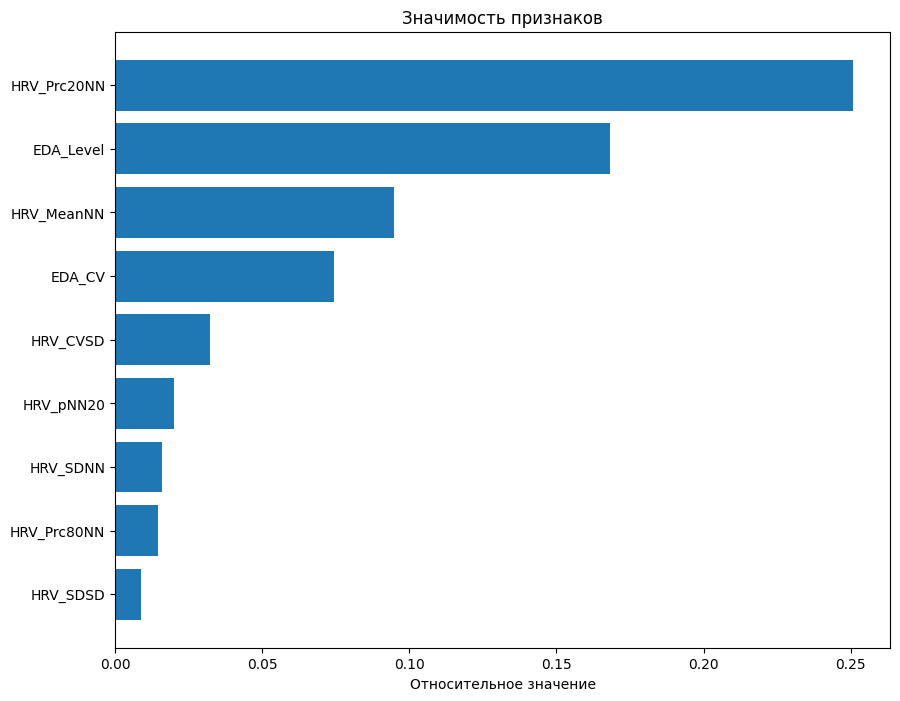

{'RF_60_20': array([0.18331943, 0.01571029, 0.03427661, 0.04699491, 0.24555442,
       0.09415695, 0.04034187, 0.23327112, 0.10637441]), 'SVM_60_20': array([5.47104452e-02, 1.78918376e-02, 2.36399687e-02, 2.15209871e-01,
       8.67183132e-06, 2.40412174e-02, 6.01732837e-02, 2.68229773e-01,
       1.75690605e+00]), 'KNN_60_20': array([0.25110471, 0.07569645, 0.09462056, 0.        , 0.30768492,
       0.17550432, 0.13823247, 0.01277618, 0.        ]), 'k-mean_60_20': array([2.58610203e+07, 2.42228192e+05, 2.93485663e+05, 7.53272410e-02,
       2.26817450e+07, 2.83376678e+07, 7.20221361e+05, 1.27215238e+02,
       6.81060739e-03]), 'gbn_60_20': array([0.07050913, 0.        , 0.0142171 , 0.00192123, 0.22103746,
       0.08107589, 0.01440922, 0.15888569, 0.09433237]), 'RF_60_15': array([0.21492988, 0.02135033, 0.03113035, 0.04822107, 0.2315745 ,
       0.09908345, 0.03753751, 0.20938722, 0.10678569]), 'SVM_60_15': array([0.06195866, 0.01094581, 0.0116518 , 0.32087265, 0.01655006,
       0.0

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(gbn_model, X_train_all, y_train_all, n_repeats=10, random_state=42)

sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 8))
plt.barh(X_train_all.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.title('Значимость признаков')
plt.xlabel('Относительное значение')
plt.show()

dict_fi[f'gbt_{window_size}_{delta}'] = result.importances_mean
print(dict_fi)

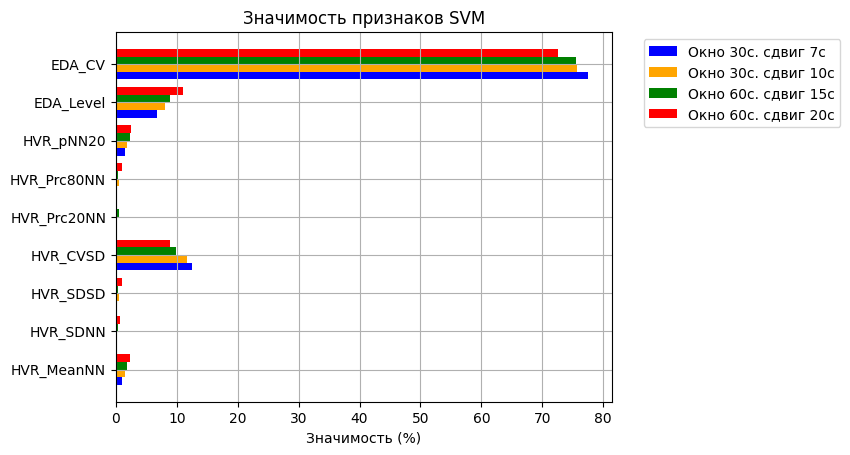

In [ ]:
dict_fix = {}
for key in dict_fi:
    total = np.sum(dict_fi[key])
    dict_fix[key] = (dict_fi[key] / total) * 100

array1 = dict_fix['SVM_30_7']
array2 = dict_fix['SVM_30_10']
array3 = dict_fix['SVM_60_15']
array4 = dict_fix['SVM_60_20']

metrics = ['HVR_MeanNN', 'HVR_SDNN', 'HVR_SDSD', 'HVR_CVSD', 'HVR_Prc20NN', 'HVR_Prc80NN', 'HVR_pNN20', 'EDA_Level', 'EDA_CV']

bar_width = 0.2

y_values = np.arange(len(array1))


plt.barh(y_values - 3*bar_width/2, array1, color='blue', height=bar_width, label='Окно 30с. сдвиг 7с')
plt.barh(y_values - bar_width/2, array2, color='orange', height=bar_width, label='Окно 30с. сдвиг 10с')
plt.barh(y_values + bar_width/2, array3, color='green', height=bar_width, label='Окно 60с. сдвиг 15с')
plt.barh(y_values + 3*bar_width/2, array4, color='red', height=bar_width, label='Окно 60с. сдвиг 20с')


plt.yticks(y_values, metrics)


plt.legend(bbox_to_anchor=(1.05, 1))

plt.xlabel('Значимость (%)' )
plt.title('Значимость признаков SVM')
plt.grid(True)

plt.show()

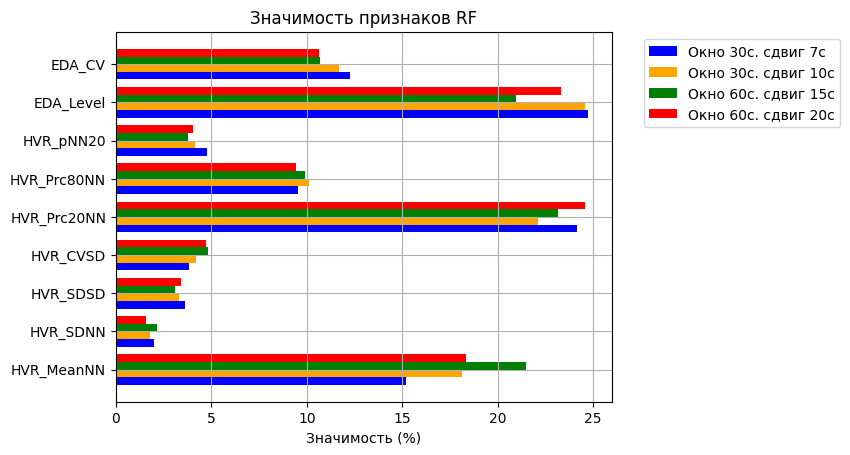

In [ ]:
array1 = dict_fix['RF_30_7']
array2 = dict_fix['RF_30_10']
array3 = dict_fix['RF_60_15']
array4 = dict_fix['RF_60_20']

metrics = ['HVR_MeanNN', 'HVR_SDNN', 'HVR_SDSD', 'HVR_CVSD', 'HVR_Prc20NN', 'HVR_Prc80NN', 'HVR_pNN20', 'EDA_Level', 'EDA_CV']

bar_width = 0.2

y_values = np.arange(len(array1))


plt.barh(y_values - 3*bar_width/2, array1, color='blue', height=bar_width, label='Окно 30с. сдвиг 7с')
plt.barh(y_values - bar_width/2, array2, color='orange', height=bar_width, label='Окно 30с. сдвиг 10с')
plt.barh(y_values + bar_width/2, array3, color='green', height=bar_width, label='Окно 60с. сдвиг 15с')
plt.barh(y_values + 3*bar_width/2, array4, color='red', height=bar_width, label='Окно 60с. сдвиг 20с')


plt.yticks(y_values, metrics)
plt.legend(bbox_to_anchor=(1.05, 1))

plt.xlabel('Значимость (%)' )
plt.title('Значимость признаков RF')
plt.grid(True)

plt.show()

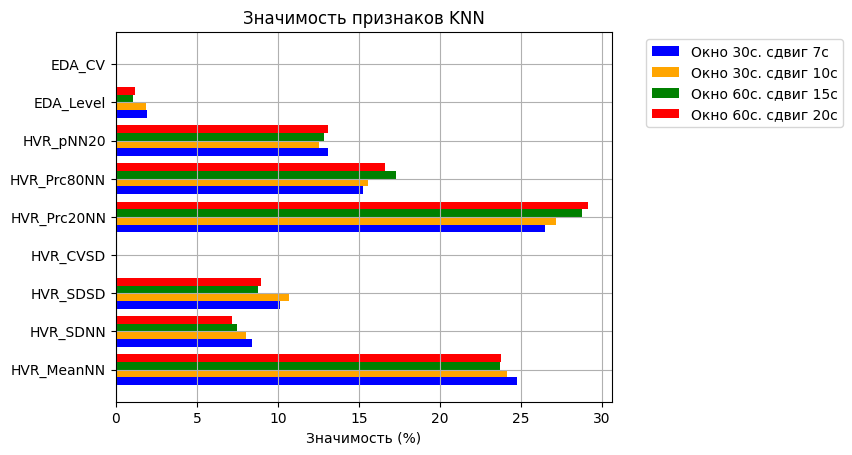

In [ ]:
array1 = dict_fix['KNN_30_7']
array2 = dict_fix['KNN_30_10']
array3 = dict_fix['KNN_60_15']
array4 = dict_fix['KNN_60_20']

metrics = ['HVR_MeanNN', 'HVR_SDNN', 'HVR_SDSD', 'HVR_CVSD', 'HVR_Prc20NN', 'HVR_Prc80NN', 'HVR_pNN20', 'EDA_Level', 'EDA_CV']

bar_width = 0.2

y_values = np.arange(len(array1))


plt.barh(y_values - 3*bar_width/2, array1, color='blue', height=bar_width, label='Окно 30с. сдвиг 7с')
plt.barh(y_values - bar_width/2, array2, color='orange', height=bar_width, label='Окно 30с. сдвиг 10с')
plt.barh(y_values + bar_width/2, array3, color='green', height=bar_width, label='Окно 60с. сдвиг 15с')
plt.barh(y_values + 3*bar_width/2, array4, color='red', height=bar_width, label='Окно 60с. сдвиг 20с')


plt.yticks(y_values, metrics)

plt.legend(bbox_to_anchor=(1.48, 1))

plt.xlabel('Значимость (%)' )
plt.title('Значимость признаков KNN')

plt.grid(True)
plt.show()

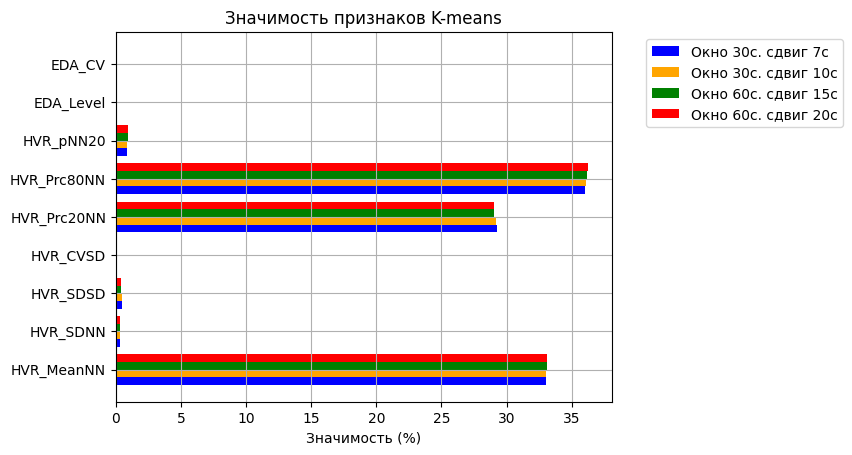

In [ ]:
array1 = dict_fix['k-means_30_7']
array2 = dict_fix['k-means_30_10']
array3 = dict_fix['k-means_60_15']
array4 = dict_fix['k-means_60_20']

metrics = ['HVR_MeanNN', 'HVR_SDNN', 'HVR_SDSD', 'HVR_CVSD', 'HVR_Prc20NN', 'HVR_Prc80NN', 'HVR_pNN20', 'EDA_Level', 'EDA_CV']

bar_width = 0.2

y_values = np.arange(len(array1))


plt.barh(y_values - 3*bar_width/2, array1, color='blue', height=bar_width, label='Окно 30с. сдвиг 7с')
plt.barh(y_values - bar_width/2, array2, color='orange', height=bar_width, label='Окно 30с. сдвиг 10с')
plt.barh(y_values + bar_width/2, array3, color='green', height=bar_width, label='Окно 60с. сдвиг 15с')
plt.barh(y_values + 3*bar_width/2, array4, color='red', height=bar_width, label='Окно 60с. сдвиг 20с')


plt.yticks(y_values, metrics)

plt.legend(bbox_to_anchor=(1.48, 1))

plt.grid(True)
plt.xlabel('Значимость (%)' )
plt.title('Значимость признаков K-means')

plt.show()

In [1]:
array1 = dict_fix['gbt_30_7']
array2 = dict_fix['gbt_30_10']
array3 = dict_fix['gbt_60_15']
array4 = dict_fix['gbt_60_20']

metrics = ['HVR_MeanNN', 'HVR_SDNN', 'HVR_SDSD', 'HVR_CVSD', 'HVR_Prc20NN', 'HVR_Prc80NN', 'HVR_pNN20', 'EDA_Level', 'EDA_CV']

bar_width = 0.2

y_values = np.arange(len(array1))


plt.barh(y_values - 3*bar_width/2, array1, color='blue', height=bar_width, label='Окно 30с. сдвиг 7с')
plt.barh(y_values - bar_width/2, array2, color='orange', height=bar_width, label='Окно 30с. сдвиг 10с')
plt.barh(y_values + bar_width/2, array3, color='green', height=bar_width, label='Окно 60с. сдвиг 15с')
plt.barh(y_values + 3*bar_width/2, array4, color='red', height=bar_width, label='Окно 60с. сдвиг 20с')


plt.yticks(y_values, metrics)

plt.legend(bbox_to_anchor=(1.05, 1))

plt.xlabel('Значимость (%)' )
plt.title('Значимость признаков GBT')
plt.grid(True)

plt.show()

NameError: name 'dict_fix' is not defined

In [ ]:
# Получение параметров модели
params = gbt_model.get_params()

print("Параметры модели gbt_model:")
for param, value in params.items():
    print(f"{param}: {value}")

In [ ]:
# joblib.dump(gbt_model, "gbn_GS_14_04-098395.joblib")
joblib.dump(gbt_model, f"/content/drive/MyDrive/ВКР/модель-дата-точность/gbt_GS_{window_size}-{delta}-{int(accuracy_gbn * 100000)}.joblib")


In [ ]:
import numpy as np
dict_fi = {'RF_60_20': np.array([0.18331943, 0.01571029, 0.03427661, 0.04699491, 0.24555442, 0.09415695, 0.04034187, 0.23327112, 0.10637441]),
           'SVM_60_20': np.array([5.47104452e-02, 1.78918376e-02, 2.36399687e-02, 2.15209871e-01, 8.67183132e-06, 2.40412174e-02, 6.01732837e-02, 2.68229773e-01, 1.75690605e+00]),
           'KNN_60_20': np.array([0.25110471, 0.07569645, 0.09462056, 0. , 0.30768492, 0.17550432, 0.13823247, 0.01277618, 0. ]),
           'k-mean_60_20': np.array([2.58610203e+07, 2.42228192e+05, 2.93485663e+05, 7.53272410e-02, 2.26817450e+07, 2.83376678e+07, 7.20221361e+05, 1.27215238e+02, 6.81060739e-03]),
           'gbt_60_20': np.array([0.07050913, 0. , 0.0142171 , 0.00192123, 0.22103746, 0.08107589, 0.01440922, 0.15888569, 0.09433237]),
           'RF_60_15': np.array([0.21492988, 0.02135033, 0.03113035, 0.04822107, 0.2315745 , 0.09908345, 0.03753751, 0.20938722, 0.10678569]),
           'SVM_60_15': np.array([0.06195866, 0.01094581, 0.0116518 , 0.32087265, 0.01655006, 0.01127669, 0.07711013, 0.29068554, 2.47197257]),
           'KNN_60_15': np.array([0.24985528, 0.07901592, 0.09269175, 0. , 0.30325615, 0.18191027, 0.13560058, 0.01136035, 0. ]),
           'k-mean_60_15': np.array([3.35167779e+07, 3.09463318e+05, 3.94085151e+05, 1.06464845e-01, 2.93941910e+07, 3.66388777e+07, 9.30521532e+05, 6.11791662e+01, 6.63849115e-03]),
           'gbt_60_15': np.array([0.05730825, 0.00318379, 0.0146165 , 0.01577424, 0.24515195, 0. , 0.00824891, 0.14956585, 0.06895803]),
           'RF_30_10': np.array([0.18101868, 0.01814622, 0.03322727, 0.04199344, 0.22088137, 0.10106632, 0.04120455, 0.24561744, 0.11684471]),
           'RF_30_7': np.array([0.1518672 , 0.01986017, 0.0360923 , 0.03810879, 0.24138729, 0.09523519, 0.04748654, 0.24738024, 0.12258229]),
           'SVM_30_7': np.array([0.05216238, 0.00751455, 0.01089589, 0.63993316, 0.00716852, 0.00840665, 0.07576578, 0.3482192 , 3.96901218]),
           'gbt_30_7': np.array([0.06281884, 0.00706344, 0.02416612, 0.01265533, 0.19372139, 0.05559189, 0.00647482, 0.18600392, 0.08701766]),
           'KNN_30_7': np.array([0.297155 , 0.10078483, 0.12141923, 0. , 0.31831262, 0.18319163, 0.15722695, 0.02285808, 0. ]),
           'k-mean_30_7': np.array([7.71767386e+07, 7.39906782e+05, 1.11807226e+06, 4.17350253e-01, 6.84612798e+07, 8.41658228e+07, 2.03726913e+06, 3.24990288e+02, 5.39282858e-03]),
           'SVM_30_10': np.array([5.68465685e-02, 9.63229385e-03, 2.04419210e-02, 4.49531142e-01, 2.76375798e-03, 1.96233904e-02, 6.79031674e-02, 3.07025382e-01, 2.90319599e+00]),
           'KNN_30_10': np.array([0.28353545, 0.09426306, 0.12504664, 0. , 0.31861007, 0.18264925, 0.1474347 , 0.02215485, 0. ]),
           'k-mean_30_10': np.array([5.53177176e+07, 5.54032529e+05, 8.02078691e+05, 3.29463208e-01, 4.89093775e+07, 6.04636845e+07, 1.49655625e+06, 1.19404780e+02, 3.07924300e-03]),
           'gbt_30_10': np.array([0.09468284, 0.01599813, 0.00872201, 0.03208955, 0.25083955, 0.01469216, 0.02010261, 0.16814366, 0.07434701])}

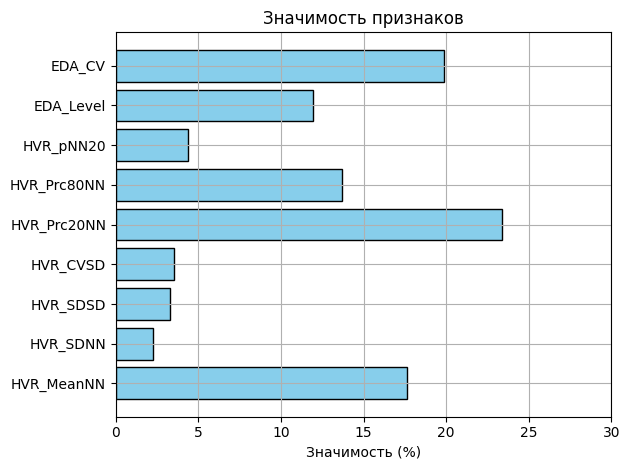

In [ ]:
import matplotlib.pyplot as plt

for key in dict_fi:
    total = np.sum(dict_fi[key])
    dict_fi[key] = (dict_fi[key] / total) * 100

feature_names = ['HVR_MeanNN', 'HVR_SDNN', 'HVR_SDSD', 'HVR_CVSD', 'HVR_Prc20NN', 'HVR_Prc80NN', 'HVR_pNN20', 'EDA_Level', 'EDA_CV']
feature_importance = [dict_fi[model] for model in dict_fi]

sum_by_index = []
for values in zip(*feature_importance):
  s = sum(values)
  sum_by_index.append(s)

sum_by_index = sum_by_index/sum(sum_by_index) * 100

fig_width = 10
fig_height = 6

fig, ax = plt.subplots()

ax.barh(feature_names, sum_by_index, color='skyblue', edgecolor='black')
ax.set_xlabel('Значимость (%)')
ax.set_title('Значимость признаков')
ax.set_xticks(range(0, 31, 5))

ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
for model in dict_fi:
  print(model)

RF_60_20
SVM_60_20
KNN_60_20
k-mean_60_20
gbt_60_20
RF_60_15
SVM_60_15
KNN_60_15
k-mean_60_15
gbt_60_15
RF_30_10
RF_30_7
SVM_30_7
gbt_30_7
KNN_30_7
k-mean_30_7
SVM_30_10
KNN_30_10
k-mean_30_10
gbt_30_10


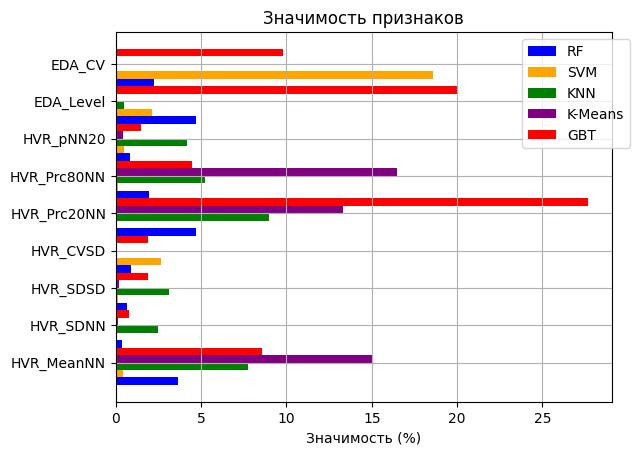

In [ ]:
RF_60_20 = dict_fix['RF_60_20']
SVM_60_20 = dict_fix['SVM_60_20']
KNN_60_20 = dict_fix['KNN_60_20']
k_mean_60_20 = dict_fix['k-mean_60_20']
gbt_60_20 = dict_fix['gbt_60_20']
RF_60_15 = dict_fix['RF_60_15']
SVM_60_15 = dict_fix['SVM_60_15']
KNN_60_15 = dict_fix['KNN_60_15']
k_mean_60_15 = dict_fix['k-mean_60_15']
gbt_60_15 = dict_fix['gbt_60_15']
RF_30_10 = dict_fix['RF_30_10']
RF_30_7 = dict_fix['RF_30_7']
SVM_30_7 = dict_fix['SVM_30_7']
gbt_30_7 = dict_fix['gbt_30_7']
KNN_30_7 = dict_fix['KNN_30_7']
k_mean_30_7 = dict_fix['k-mean_30_7']
SVM_30_10 = dict_fix['SVM_30_10']
KNN_30_10 = dict_fix['KNN_30_10']
k_mean_30_10 = dict_fix['k-mean_30_10']
gbt_30_10 = dict_fix['gbt_30_10']

RF_sum = RF_60_20 + RF_60_15 + RF_30_10 + RF_30_7
SVM_sum = SVM_60_20 + SVM_60_15 + SVM_30_10 + SVM_30_7
KNN_sum = KNN_60_20 + KNN_60_15 + KNN_30_10 + KNN_30_7
k_mean_sum = k_mean_60_20 + k_mean_60_15 + k_mean_30_10 + k_mean_30_7
gbt_sum = gbt_60_20 + gbt_60_15 + gbt_30_10 + gbt_30_7

RF_sum = RF_sum / sum(RF_sum+SVM_sum+KNN_sum+k_mean_sum+gbt_sum) * 100
SVM_sum = SVM_sum / sum(RF_sum+SVM_sum+KNN_sum+k_mean_sum+gbt_sum) * 100
KNN_sum = KNN_sum / sum(RF_sum+SVM_sum+KNN_sum+k_mean_sum+gbt_sum) * 100
k_mean_sum = k_mean_sum / sum(RF_sum+SVM_sum+KNN_sum+k_mean_sum+gbt_sum) * 100
gbt_sum = gbt_sum / sum(RF_sum+SVM_sum+KNN_sum+k_mean_sum+gbt_sum) * 100



fi = zip(*feature_importance)


metrics = ['HVR_MeanNN', 'HVR_SDNN', 'HVR_SDSD', 'HVR_CVSD', 'HVR_Prc20NN', 'HVR_Prc80NN', 'HVR_pNN20', 'EDA_Level', 'EDA_CV']

bar_width = 0.2  # Уменьшим ширину столбцов для более ясного отображения
y_values = np.arange(9)

plt.barh(y_values - 2.5*bar_width, RF_sum, color='blue', height=bar_width, label='RF')
plt.barh(y_values - 1.5*bar_width, SVM_sum, color='orange', height=bar_width, label='SVM')
plt.barh(y_values - 0.5*bar_width, KNN_sum, color='green', height=bar_width, label='KNN')
plt.barh(y_values + 0.5*bar_width, k_mean_sum, color='purple', height=bar_width, label='K-Means')
plt.barh(y_values + 1.5*bar_width, gbt_sum, color='red', height=bar_width, label='GBT')


plt.yticks(y_values, metrics)

plt.legend(bbox_to_anchor=(1.05, 1))

plt.xlabel('Значимость (%)' )
plt.title('Значимость признаков')
ax.set_xticks(range(0, 31, 5))
plt.grid(True)

plt.show()

In [ ]:
sum(sum_by_index/sum(sum_by_index))

1.0

In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   28G   81G  26% /
tmpfs            64M     0   64M   0% /dev
shm             5.8G     0  5.8G   0% /dev/shm
/dev/root       2.0G  1.1G  849M  57% /usr/sbin/docker-init
tmpfs           6.4G  208K  6.4G   1% /var/colab
/dev/sda1        70G   46G   25G  65% /kaggle/input
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
addres